In [1]:
import numpy as np
import pandas as pd

# for handling categorical variables
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import PolynomialFeatures

# file system management
import os

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

#matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

In [2]:
print(os.listdir())

['.DS_Store', 'Bank Churn Prediction.py', 'Bank Churn Prediction.ipynb', 's.csv', 'test.csv', 'Bank Churn Prediction v2.ipynb', 'Bank Churn Prediction - Jupyter Notebook_files', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


In [3]:
print(os.getcwd())

/Users/yangzifan/Kaggle/Bank Churn Prediction


In [4]:
train = pd.read_csv("/Users/yangzifan/Kaggle/Bank Churn Prediction/train.csv")
print('Training data shape:',train.shape)
train.head()

Training data shape: (165034, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
test = pd.read_csv("/Users/yangzifan/Kaggle/Bank Churn Prediction/test.csv")
print('Testing data shape:',test.shape)
test.head()

Testing data shape: (110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [6]:
train['Exited'].value_counts()  #imbalanced class problem, model improvement later

0    130113
1     34921
Name: Exited, dtype: int64

In [7]:
missing_values = train.isnull().sum()
missing_values.head(14)

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
train.dtypes.value_counts()

int64      6
float64    5
object     3
dtype: int64

In [9]:
train.select_dtypes("object").apply(pd.Series.nunique,axis=0)

Surname      2797
Geography       3
Gender          2
dtype: int64

In [10]:
train['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
train.select_dtypes("int64").apply(pd.Series.nunique,axis=0)

id               165034
CustomerId        23221
CreditScore         457
Tenure               11
NumOfProducts         4
Exited                2
dtype: int64

In [12]:
train.select_dtypes("float64").apply(pd.Series.nunique,axis=0)

Age                   71
Balance            30075
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
dtype: int64

In [13]:
cat_cols = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember']
num_cols = ['CreditScore','Age','Balance','EstimatedSalary']
target = 'Exited'

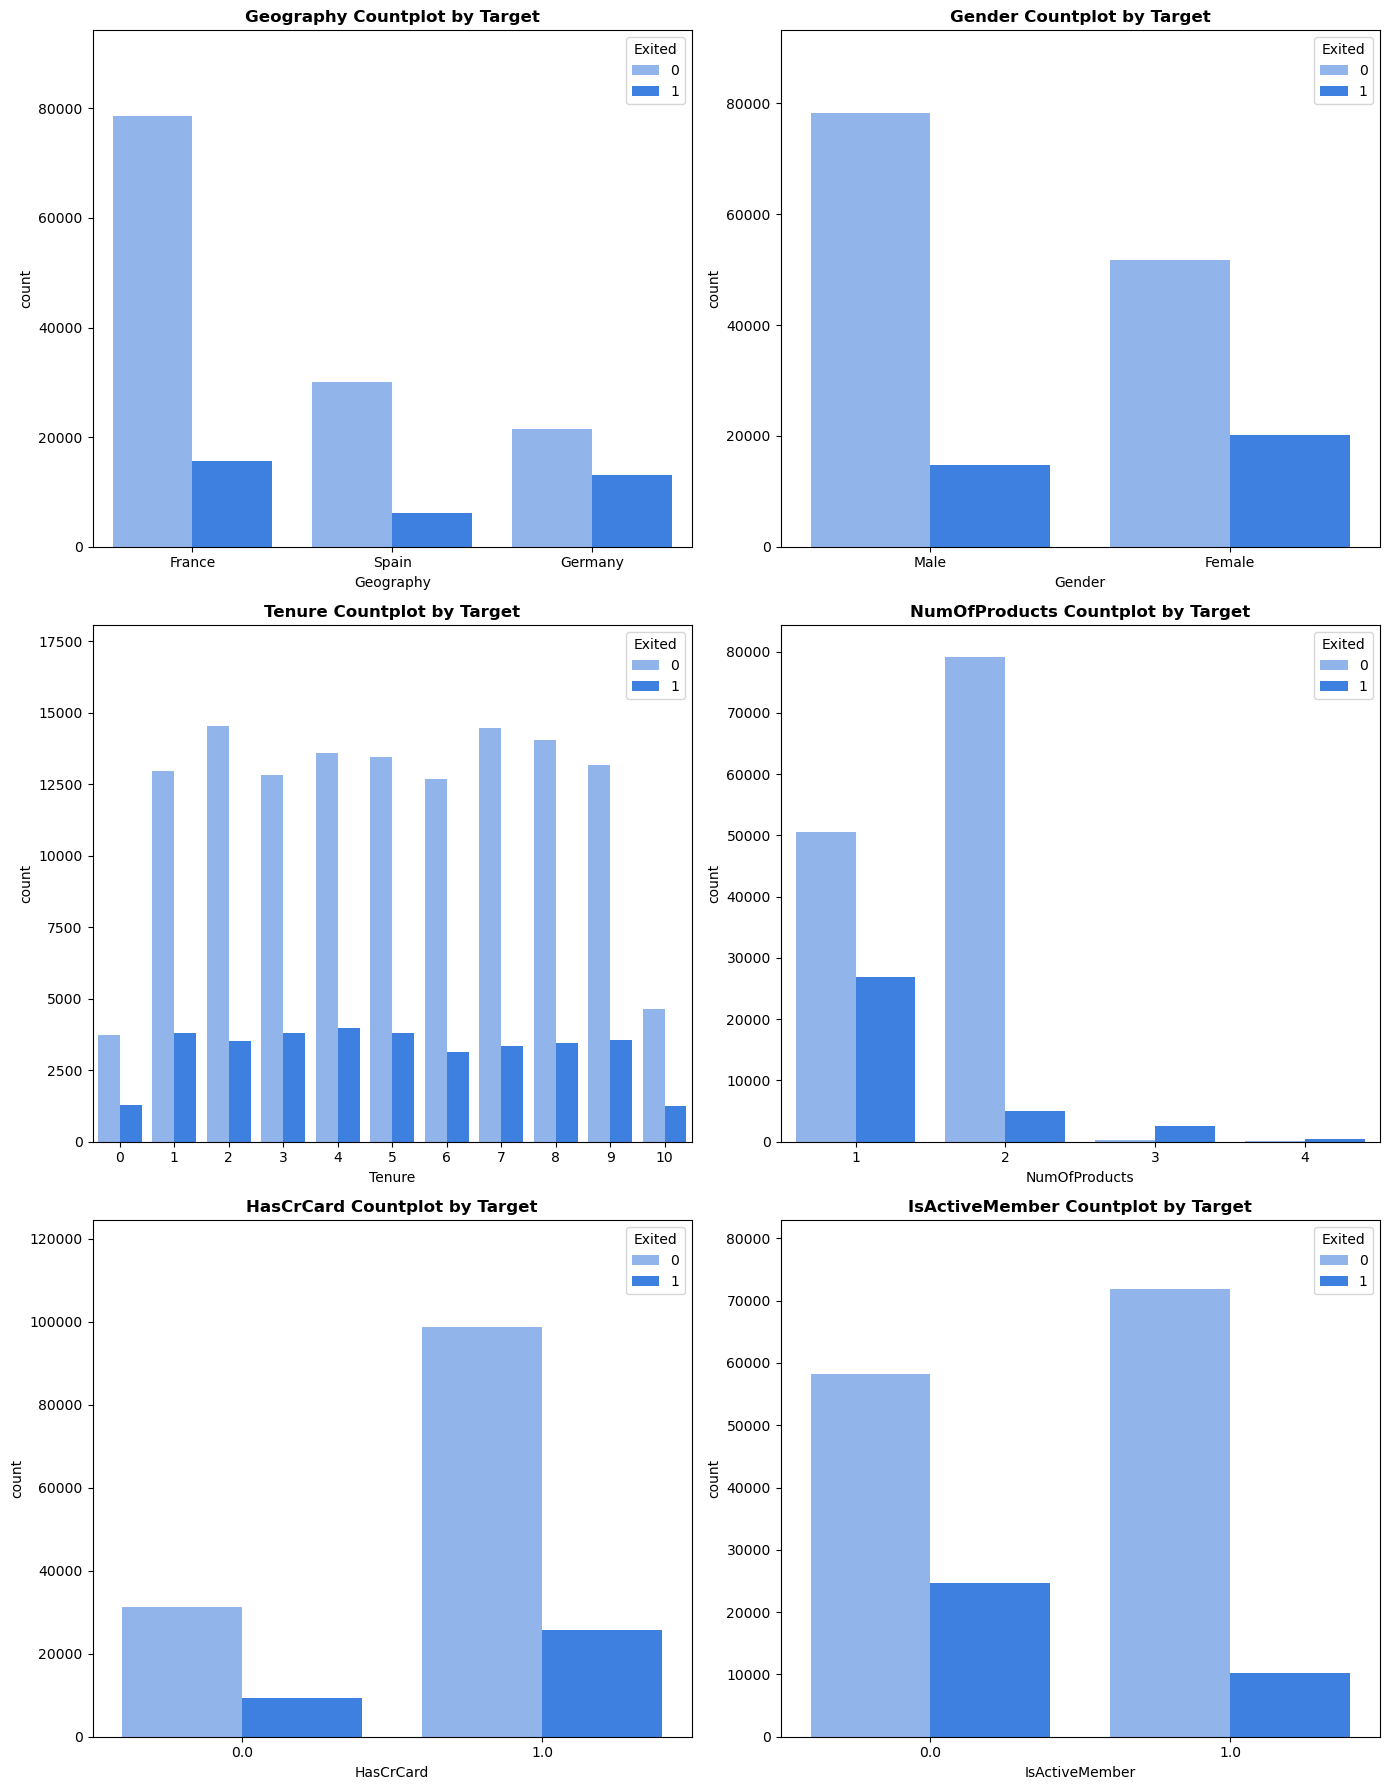

In [14]:
fig = plt.figure(figsize=(14, len(cat_cols)*3))

for i, col in enumerate(cat_cols):
    
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue = target, data=train, palette=['#82b1fa','#237bfa']) #237bfa is dark blue
    plt.title(f"{col} Countplot by Target", fontweight = 'bold')
    plt.ylim(0, train[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

In [15]:
train[num_cols].describe()

,CreditScore,Age,Balance,EstimatedSalary
count,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,55478.086689,112574.822734
std,80.103340,8.867205,62817.663278,50292.865585
min,350.000000,18.000000,0.000000,11.580000
25%,597.000000,32.000000,0.000000,74637.570000
50%,659.000000,37.000000,0.000000,117948.000000
75%,710.000000,42.000000,119939.517500,155152.467500
max,850.000000,92.000000,250898.090000,199992.480000


<Figure size 800x600 with 0 Axes>

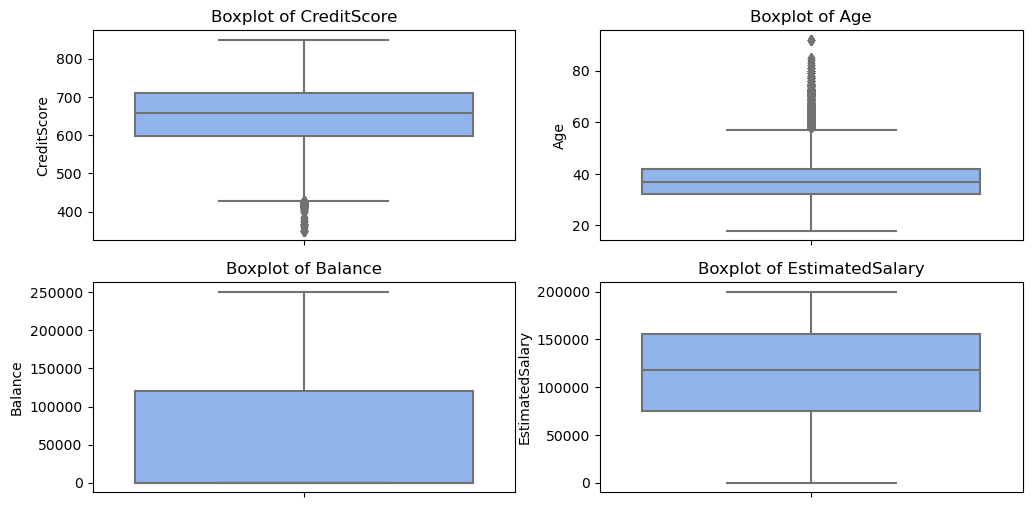

In [16]:
plt.figure(figsize=(8, 6))
n_cols = 2
n_rows = (len(num_cols)+1)//n_cols # Calculate the number of rows needed
# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
# Flatten the axes array for easy iteration
axes = axes.flatten()
# Loop through each column and create a boxplot in its subplot
for i, col in enumerate(num_cols):
    sns.boxplot(y=train[col], ax=axes[i],palette=['#82b1fa'])
    axes[i].set_title(f'Boxplot of {col}')

# Remove any unused subplots (if the number of plots is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()
# potentially removing these outliers

<Figure size 800x600 with 0 Axes>

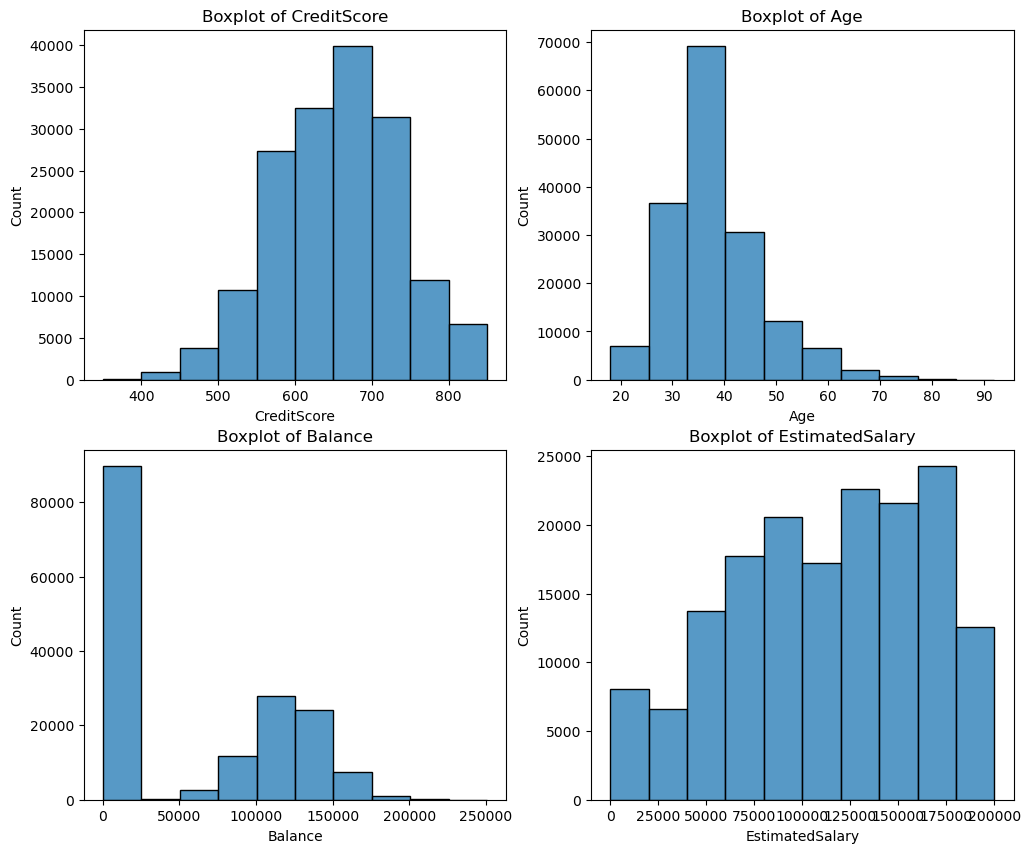

In [17]:
plt.figure(figsize=(8, 6))
n_cols = 2
n_rows = (len(num_cols)+1)//n_cols # Calculate the number of rows needed
# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10)) 
# if the second figure in figsize is too small, then the 
# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and create a boxplot in its subplot
for i, col in enumerate(num_cols):
    # Calculate mean and median
    mean_value = train[col].mean()
    median_value = train[col].median()
    # Add mean and median lines
    sns.histplot(x=train[col], ax=axes[i],palette=['#82b1fa'],bins=10)
    axes[i].set_title(f'Boxplot of {col}')

# Remove any unused subplots (if the number of plots is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [18]:
for col in num_cols:
    sc = MinMaxScaler()
    train[col+"_scaled"] = sc.fit_transform(train[[col]])
    test[col+"_scaled"] = sc.fit_transform(test[[col]])
train.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_scaled,Age_scaled,Balance_scaled,EstimatedSalary_scaled
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.636,0.202703,0.000000,0.907279
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.554,0.202703,0.000000,0.247483
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.656,0.297297,0.000000,0.924364
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.462,0.216216,0.593398,0.422787
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.732,0.202703,0.000000,0.075293


In [19]:
# Below are the new features added based on domain knowledge
# need to perform this transformation before getting dummies since the categorical variables will be removed, see cat_cols above
def add_new_features(df):
    df['AgeGroup'] = df['Age'] // 10 * 10
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['QualityOfBalance'] = pd.cut(df['Balance'], bins=[-1,100,1000,10000,50000,300000], labels=['VeryLow', 'Low', 'Medium','High','Highest'])
    df['QualityOfBalance'].replace(['VeryLow', 'Low', 'Medium','High','Highest'],[0,1,2,3,4], inplace=True)
    df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
    df['CreditScoreTier'] = pd.cut(df['CreditScore'], bins=[0, 650, 750, 850], labels=['Low', 'Medium', 'High'])
    df['CreditScoreTier'].replace(['Low', 'Medium', 'High'],[0, 1, 2], inplace=True)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']  
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['Customer_Loyalty_Status'] = df['Tenure'].apply(lambda x:0 if x < 2 else 1)
    return df

In [20]:
def get_vectors(df_train,df_test,col_name):

    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    
    #Dimensionality Reduction Using SVD ( Singular Value Decompostion)
    svd = TruncatedSVD(3)
    x_sv_train = svd.fit_transform(vectors_train)
    x_sv_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_sv_train)
    tfidf_df_test = pd.DataFrame(x_sv_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    return df_train,df_test


In [21]:
train['CusId_Sur'] = train['CustomerId'].astype('str')+train['Surname']

In [22]:
test['CusId_Sur'] = test['CustomerId'].astype('str')+test['Surname']

In [23]:
train,test = get_vectors(train,test,'CusId_Sur') #there might be a relationship between the surnames in each country

In [24]:
#Generating New Features
train = add_new_features(train)
test = add_new_features(test)

In [25]:
train=pd.get_dummies(train,columns=cat_cols,drop_first=True)

In [26]:
train.columns #len(train.columns)=30

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance',
       'EstimatedSalary', 'Exited', 'CreditScore_scaled', 'Age_scaled',
       'Balance_scaled', 'EstimatedSalary_scaled', 'CusId_Sur',
       'CusId_Sur_tfidf_0', 'CusId_Sur_tfidf_1', 'CusId_Sur_tfidf_2',
       'AgeGroup', 'IsSenior', 'QualityOfBalance', 'Balance_to_Salary_Ratio',
       'CreditScoreTier', 'IsActive_by_CreditCard', 'Products_Per_Tenure',
       'Customer_Loyalty_Status', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4',
       'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
       'HasCrCard_1.0', 'IsActiveMember_1.0'],
      dtype='object')

In [27]:
test=pd.get_dummies(test,columns=cat_cols,drop_first=True)
#test = test.drop("id",axis=1)

In [28]:
test.columns #len(test.columns)=29, the difference is Exited

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance',
       'EstimatedSalary', 'CreditScore_scaled', 'Age_scaled', 'Balance_scaled',
       'EstimatedSalary_scaled', 'CusId_Sur', 'CusId_Sur_tfidf_0',
       'CusId_Sur_tfidf_1', 'CusId_Sur_tfidf_2', 'AgeGroup', 'IsSenior',
       'QualityOfBalance', 'Balance_to_Salary_Ratio', 'CreditScoreTier',
       'IsActive_by_CreditCard', 'Products_Per_Tenure',
       'Customer_Loyalty_Status', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4',
       'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
       'HasCrCard_1.0', 'IsActiveMember_1.0'],
      dtype='object')

In [29]:
correlations = train.corr()['Exited'].sort_values()
print(correlations)

NumOfProducts_2           -0.378176
IsActiveMember_1.0        -0.210237
IsActive_by_CreditCard    -0.178343
Gender_Male               -0.146442
Geography_Spain           -0.051175
CreditScore_scaled        -0.027383
CreditScore               -0.027383
HasCrCard_1.0             -0.022141
Tenure_7                  -0.020444
Customer_Loyalty_Status   -0.020173
Tenure_2                  -0.014371
Tenure_8                  -0.011520
Tenure_6                  -0.010225
CustomerId                -0.009947
CusId_Sur_tfidf_0         -0.008831
CusId_Sur_tfidf_1         -0.002764
Tenure_9                   0.000413
Tenure_10                  0.000532
Balance_to_Salary_Ratio    0.001559
id                         0.002512
Tenure_5                   0.007082
CusId_Sur_tfidf_2          0.007161
Tenure_1                   0.011964
Tenure_4                   0.012491
Tenure_3                   0.014347
EstimatedSalary_scaled     0.018827
EstimatedSalary            0.018827
IsSenior                   0

In [30]:
# Extract the variables and show correlations
ext_data = train[['NumOfProducts_2','IsActiveMember_1.0','Gender_Male','Age_scaled','NumOfProducts_3','Geography_Germany',
                 'Balance_scaled','NumOfProducts_4']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,NumOfProducts_2,IsActiveMember_1.0,Gender_Male,Age_scaled,NumOfProducts_3,Geography_Germany,Balance_scaled,NumOfProducts_4
NumOfProducts_2,1.000000,0.073808,0.049889,-0.167109,-0.136503,-0.145188,-0.412818,-0.054894
IsActiveMember_1.0,0.073808,1.000000,0.033722,0.003320,-0.047415,-0.036433,-0.015073,-0.016840
Gender_Male,0.049889,0.033722,1.000000,-0.063139,-0.030953,-0.039465,-0.014699,-0.015764
Age_scaled,-0.167109,0.003320,-0.063139,1.000000,0.081710,0.093138,0.064318,0.038385
NumOfProducts_3,-0.136503,-0.047415,-0.030953,0.081710,1.000000,0.043791,0.019056,-0.007178
Geography_Germany,-0.145188,-0.036433,-0.039465,0.093138,0.043791,1.000000,0.539208,0.029284
Balance_scaled,-0.412818,-0.015073,-0.014699,0.064318,0.019056,0.539208,1.000000,0.023764
NumOfProducts_4,-0.054894,-0.016840,-0.015764,0.038385,-0.007178,0.029284,0.023764,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

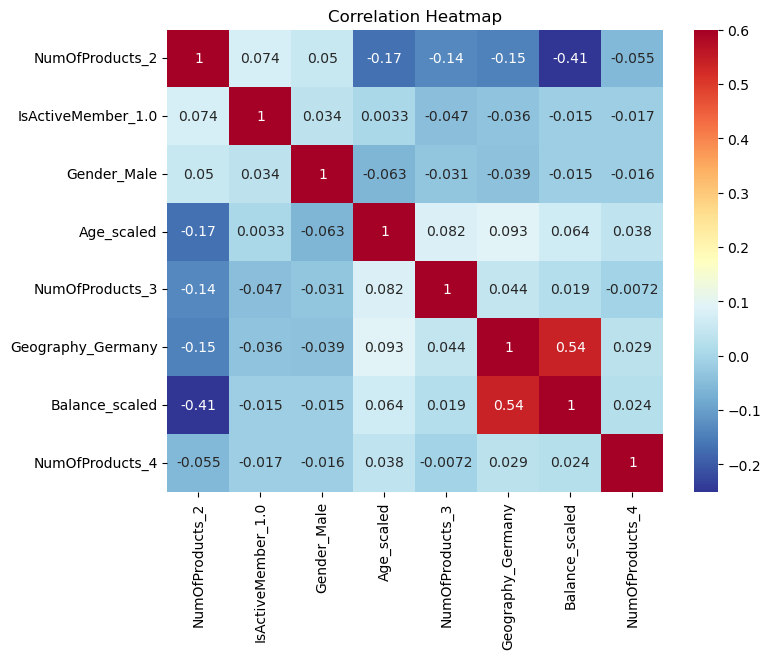

In [31]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')
# we can see there is a relatively strong correlation (abs value greater than 0.1) between numofproducts2 
# and age_scaled, numofproducts3, geography_germany, balance_scaled, so we are going to add polynomial 
# features for them

In [32]:
# Extract the variables and show correlations
ext_data2 = train[['NumOfProducts_2','Age_scaled','NumOfProducts_3','Geography_Germany',
                 'Balance_scaled']]
ext_data_corrs2 = ext_data2.corr()
ext_data_corrs2

,NumOfProducts_2,Age_scaled,NumOfProducts_3,Geography_Germany,Balance_scaled
NumOfProducts_2,1.000000,-0.167109,-0.136503,-0.145188,-0.412818
Age_scaled,-0.167109,1.000000,0.081710,0.093138,0.064318
NumOfProducts_3,-0.136503,0.081710,1.000000,0.043791,0.019056
Geography_Germany,-0.145188,0.093138,0.043791,1.000000,0.539208
Balance_scaled,-0.412818,0.064318,0.019056,0.539208,1.000000


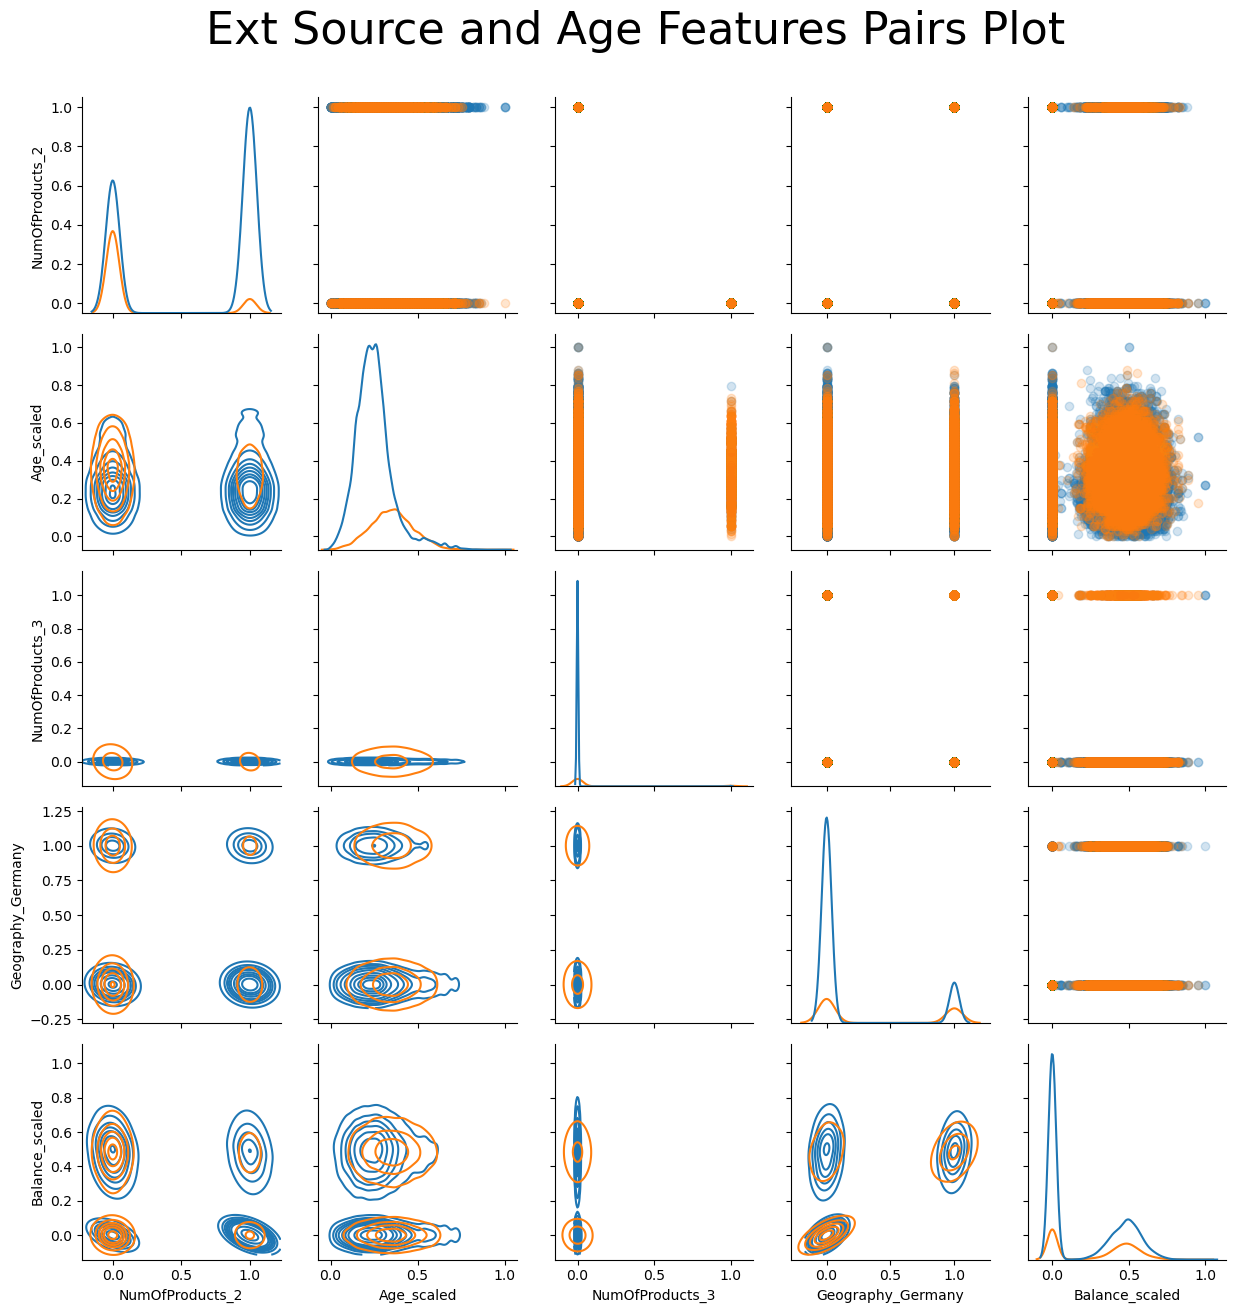

In [33]:
# pairs plot
# # Copy the data for plotting
plot_data = ext_data2.copy()
plot_data['TARGET'] = train['Exited']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In [34]:
# make polynomial features
poly_features = train[['NumOfProducts_2','Age_scaled','NumOfProducts_3','Geography_Germany',
                 'Balance_scaled']]
poly_features_test = test[['NumOfProducts_2','Age_scaled','NumOfProducts_3','Geography_Germany',
                 'Balance_scaled']]
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [35]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (165034, 56)


In [36]:
poly_transformer.get_feature_names_out(input_features =['NumOfProducts_2','Age_scaled','NumOfProducts_3','Geography_Germany',
                 'Balance_scaled'])[:15]

array(['1', 'NumOfProducts_2', 'Age_scaled', 'NumOfProducts_3',
       'Geography_Germany', 'Balance_scaled', 'NumOfProducts_2^2',
       'NumOfProducts_2 Age_scaled', 'NumOfProducts_2 NumOfProducts_3',
       'NumOfProducts_2 Geography_Germany',
       'NumOfProducts_2 Balance_scaled', 'Age_scaled^2',
       'Age_scaled NumOfProducts_3', 'Age_scaled Geography_Germany',
       'Age_scaled Balance_scaled'], dtype=object)

In [37]:
train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance',
       'EstimatedSalary', 'Exited', 'CreditScore_scaled', 'Age_scaled',
       'Balance_scaled', 'EstimatedSalary_scaled', 'CusId_Sur',
       'CusId_Sur_tfidf_0', 'CusId_Sur_tfidf_1', 'CusId_Sur_tfidf_2',
       'AgeGroup', 'IsSenior', 'QualityOfBalance', 'Balance_to_Salary_Ratio',
       'CreditScoreTier', 'IsActive_by_CreditCard', 'Products_Per_Tenure',
       'Customer_Loyalty_Status', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4',
       'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
       'HasCrCard_1.0', 'IsActiveMember_1.0'],
      dtype='object')

In [38]:
test.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance',
       'EstimatedSalary', 'CreditScore_scaled', 'Age_scaled', 'Balance_scaled',
       'EstimatedSalary_scaled', 'CusId_Sur', 'CusId_Sur_tfidf_0',
       'CusId_Sur_tfidf_1', 'CusId_Sur_tfidf_2', 'AgeGroup', 'IsSenior',
       'QualityOfBalance', 'Balance_to_Salary_Ratio', 'CreditScoreTier',
       'IsActive_by_CreditCard', 'Products_Per_Tenure',
       'Customer_Loyalty_Status', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4',
       'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
       'HasCrCard_1.0', 'IsActiveMember_1.0'],
      dtype='object')

In [39]:
# Put test features into dataframe
poly_features_train = pd.DataFrame(poly_features, 
                                  columns = poly_transformer.get_feature_names_out(['NumOfProducts_2',
                'Age_scaled','NumOfProducts_3','Geography_Germany','Balance_scaled']))
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['NumOfProducts_2',
                'Age_scaled','NumOfProducts_3','Geography_Germany','Balance_scaled']))

# Concat polynomial features onto training dataframe
train_poly = pd.concat([train, poly_features_train], axis=1)

# Concat polynomial features onto testing dataframe
test_poly = pd.concat([test, poly_features_test], axis=1)

# Align the dataframes
train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)
train_poly = pd.concat([train_poly,train['Exited']],axis=1)

# Print out the new shapes
print('Training data with polynomial features shape: ', train_poly.shape)
print('Testing data with polynomial features shape:  ', test_poly.shape)

Training data with polynomial features shape:  (165034, 108)
Testing data with polynomial features shape:   (110023, 107)


In [40]:
train = train_poly
train.columns

Index(['1', 'Age', 'AgeGroup', 'Age_scaled', 'Age_scaled', 'Age_scaled',
       'Age_scaled', 'Age_scaled Balance_scaled',
       'Age_scaled Balance_scaled^2', 'Age_scaled Geography_Germany',
       ...
       'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7',
       'Tenure_8', 'Tenure_9', 'id', 'Exited'],
      dtype='object', length=108)

In [41]:
test = test_poly
test.columns

Index(['1', 'Age', 'AgeGroup', 'Age_scaled', 'Age_scaled', 'Age_scaled',
       'Age_scaled', 'Age_scaled Balance_scaled',
       'Age_scaled Balance_scaled^2', 'Age_scaled Geography_Germany',
       ...
       'Tenure_10', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6',
       'Tenure_7', 'Tenure_8', 'Tenure_9', 'id'],
      dtype='object', length=107)

In [42]:
##Selecting Columns For use 
feat_cols=train.columns.drop(['id', 'CustomerId', 'Surname','CusId_Sur','Exited'])
feat_cols=feat_cols.drop(num_cols)

print(feat_cols)

Index(['1', 'AgeGroup', 'Age_scaled', 'Age_scaled', 'Age_scaled', 'Age_scaled',
       'Age_scaled Balance_scaled', 'Age_scaled Balance_scaled^2',
       'Age_scaled Geography_Germany',
       'Age_scaled Geography_Germany Balance_scaled',
       'Age_scaled Geography_Germany^2', 'Age_scaled NumOfProducts_3',
       'Age_scaled NumOfProducts_3 Balance_scaled',
       'Age_scaled NumOfProducts_3 Geography_Germany',
       'Age_scaled NumOfProducts_3^2', 'Age_scaled^2',
       'Age_scaled^2 Balance_scaled', 'Age_scaled^2 Geography_Germany',
       'Age_scaled^2 NumOfProducts_3', 'Age_scaled^3', 'Balance_scaled',
       'Balance_scaled', 'Balance_scaled', 'Balance_scaled',
       'Balance_scaled^2', 'Balance_scaled^3', 'Balance_to_Salary_Ratio',
       'CreditScoreTier', 'CreditScore_scaled', 'CusId_Sur_tfidf_0',
       'CusId_Sur_tfidf_1', 'CusId_Sur_tfidf_2', 'Customer_Loyalty_Status',
       'EstimatedSalary_scaled', 'Gender_Male', 'Geography_Germany',
       'Geography_Germany', 'Geog

In [43]:
non_numeric_columns = train[feat_cols].select_dtypes(include=['object', 'category', 'string']).columns

print("Non-numeric columns:")
print(non_numeric_columns)

Non-numeric columns:
Index(['CreditScoreTier', 'QualityOfBalance'], dtype='object')


In [44]:
train['CreditScoreTier'].head() # need to convert this column to numeric otherwise logistic regression will not work

0    1
1    0
2    1
3    0
4    1
Name: CreditScoreTier, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [45]:
train['QualityOfBalance'].head()

0    0
1    0
2    0
3    4
4    0
Name: QualityOfBalance, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [46]:
train['CreditScoreTier'].astype('category').cat.codes
train['QualityOfBalance'].astype('category').cat.codes

0         0
1         0
2         0
3         4
4         0
         ..
165029    0
165030    0
165031    0
165032    4
165033    0
Length: 165034, dtype: int8

In [53]:
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg = LogisticRegression()  
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Regularization strength
    'max_iter': [150000], # a higher max_iter for convergence
    'solver': ['lbfgs']
}

# Set up GridSearchCV with Stratified K-Folds
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=strat_kf, scoring='roc_auc', n_jobs=-1)
# we only pick one estimator for each grid search
# 

# Fit the model to the data (this performs the cross-validation and hyperparameter tuning)
grid_search.fit(train[feat_cols], train['Exited'])

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

cv_results = grid_search.cv_results_
print(f'Best Cross-Validated ROC AUC Score: {grid_search.best_score_:.4f}')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters: {'C': 1291.5496650148827, 'max_iter': 150000, 'solver': 'lbfgs'}
Best Cross-Validated ROC AUC Score: 0.8855


In [48]:
print(feat_cols)

Index(['1', 'AgeGroup', 'Age_scaled', 'Age_scaled', 'Age_scaled', 'Age_scaled',
       'Age_scaled Balance_scaled', 'Age_scaled Balance_scaled^2',
       'Age_scaled Geography_Germany',
       'Age_scaled Geography_Germany Balance_scaled',
       'Age_scaled Geography_Germany^2', 'Age_scaled NumOfProducts_3',
       'Age_scaled NumOfProducts_3 Balance_scaled',
       'Age_scaled NumOfProducts_3 Geography_Germany',
       'Age_scaled NumOfProducts_3^2', 'Age_scaled^2',
       'Age_scaled^2 Balance_scaled', 'Age_scaled^2 Geography_Germany',
       'Age_scaled^2 NumOfProducts_3', 'Age_scaled^3', 'Balance_scaled',
       'Balance_scaled', 'Balance_scaled', 'Balance_scaled',
       'Balance_scaled^2', 'Balance_scaled^3', 'Balance_to_Salary_Ratio',
       'CreditScoreTier', 'CreditScore_scaled', 'CusId_Sur_tfidf_0',
       'CusId_Sur_tfidf_1', 'CusId_Sur_tfidf_2', 'Customer_Loyalty_Status',
       'EstimatedSalary_scaled', 'Gender_Male', 'Geography_Germany',
       'Geography_Germany', 'Geog

In [49]:
# 7. Make predictions and evaluate metrics on each fold if needed

y_pred = cross_val_predict(best_model, train[feat_cols], train['Exited'], cv=strat_kf)
y_pred_proba = cross_val_predict(best_model, train[feat_cols], train['Exited'], cv=strat_kf, method='predict_proba')[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(train['Exited'], y_pred)
precision = precision_score(train['Exited'], y_pred)
recall = recall_score(train['Exited'], y_pred)
f1 = f1_score(train['Exited'], y_pred)
roc_auc = roc_auc_score(train['Exited'], y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(train['Exited'], y_pred)
print('Confusion Matrix:')
print(conf_matrix)

class_report = classification_report(train['Exited'], y_pred)
print('Classification Report:')
print(class_report)

Accuracy: 0.8640
Precision: 0.7405
Recall: 0.5502
F1 Score: 0.6313
ROC AUC Score: 0.8855
Confusion Matrix:
[[123379   6734]
 [ 15707  19214]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    130113
           1       0.74      0.55      0.63     34921

    accuracy                           0.86    165034
   macro avg       0.81      0.75      0.77    165034
weighted avg       0.86      0.86      0.86    165034



In [50]:
predictions = best_model.predict(test[feat_cols])
y_pred_prob2 = best_model.predict_proba(test[feat_cols])[:, 1]

In [52]:
s1 = pd.DataFrame(y_pred_prob2, columns = ['Exited'])
s1 = pd.concat([test['id'], s1], axis=1)
s1.to_csv('s1.csv', index=False)
s1.head()

,id,Exited
0,165034,0.009459
1,165035,0.783902
2,165036,0.039192
3,165037,0.309309
4,165038,0.435223


In [54]:
# Extract feature importance (coefficients)
feature_importance = best_model.coef_[0]  # [0] for binary classification

In [55]:
# Get the feature names (if you're using a pandas DataFrame for X_train)
features = train[feat_cols].columns

In [56]:
# Create a DataFrame to hold feature names and their corresponding importance
coef_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort the DataFrame by importance
coef_df = coef_df.sort_values(by='Importance', ascending=False)

In [63]:
len(train[feat_cols].columns)

159

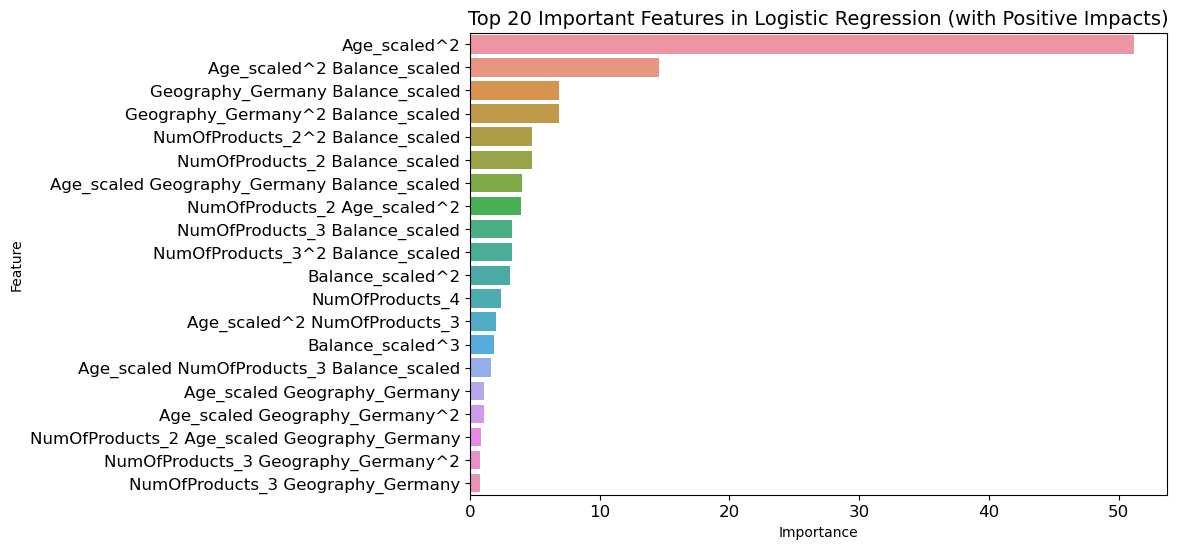

In [113]:
# Plotting with larger font sizes
plt.figure(figsize=(9, 6))
sns.barplot(x='Importance', y='Feature', data=coef_df[:20])

# Adjust y-axis label font size and make title more readable
plt.yticks(fontsize=12)  # Change the font size of y-axis labels
plt.xticks(fontsize=12)  # Optional: Change x-axis font size too
plt.title('Top 20 Important Features in Logistic Regression (with Positive Impacts)', fontsize=14)  # Title font size

plt.savefig('Top 20 Important Features in Logistic Regression (with Positive Impacts).png', bbox_inches='tight', dpi=300)
plt.show()

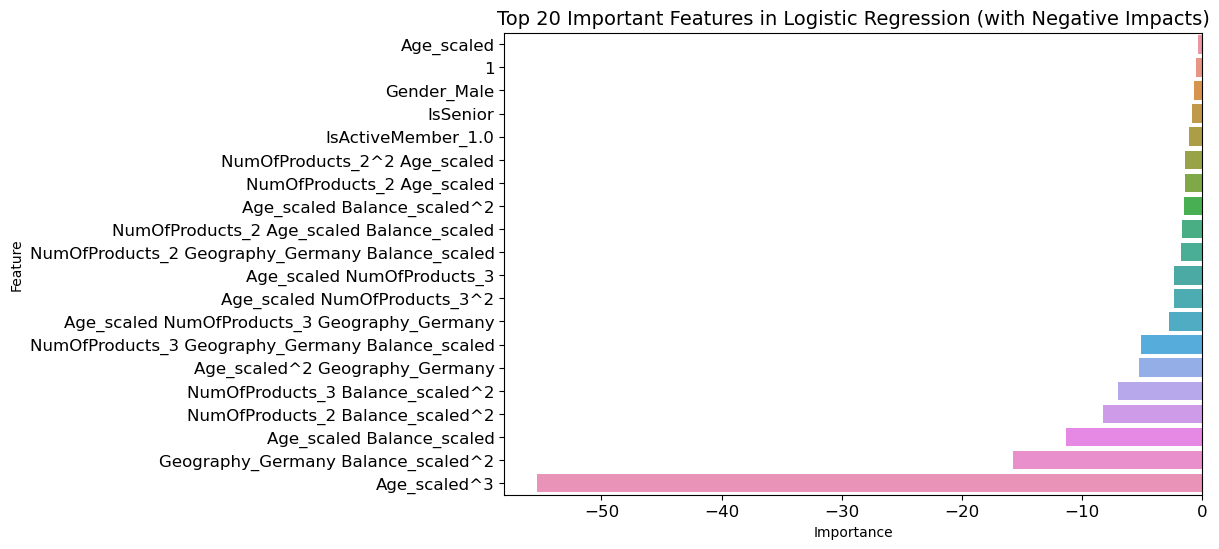

In [114]:
# Plotting with larger font sizes
plt.figure(figsize=(9, 6))
sns.barplot(x='Importance', y='Feature', data=coef_df[-20:])

# Adjust y-axis label font size and make title more readable
plt.yticks(fontsize=12)  # Change the font size of y-axis labels
plt.xticks(fontsize=12)  # Optional: Change x-axis font size too
plt.title('Top 20 Important Features in Logistic Regression (with Negative Impacts)', fontsize=14)  # Title font size

plt.savefig('Top 20 Important Features in Logistic Regression (with Negative Impacts).png', bbox_inches='tight', dpi=300) 
plt.show()